In [1]:
import sys

sys.path.append("../")

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output
%matplotlib inline

In [3]:
import neural.binary_modules as bm
import neural.models as models
import utilities as utils

#### Trainloop

In [4]:
def plot_values(values, subplot=None, **kwargs):
    # clear_output(True)
    if subplot:
        plt.subplot(*subplot)
  
    plt.plot(np.arange(len(values)) + 1, values, **kwargs)
    plt.xlabel("n_epoch")
    plt.legend()
    # plt.show()


def matrix_accuracy(A: np.array, B: np.array):
    assert A.shape == B.shape
    return 1 - np.sum(np.abs(A - B)) / A.size


def density(A: np.array):
    return A.sum() / np.size(A)

In [5]:
def train_over_matrix(matrix, model, criterion, optimizer,
                      batch_size=32, n_epochs=10, draw_plots=True):
    
    train_loader = DataLoader(utils.matrix_to_ids(matrix), batch_size=batch_size)
    losses_per_epoch = list()
    fact_acc = list()
    intermediate_user_factors = list()
    intermediate_item_factors = list()
    user_emb_grads = list()       # user_embedding.weight
    item_emb_grads = list()       # item_embedding.weight
    approx_densities = list()

    for epoch in tqdm(range(n_epochs)):
        losses_per_batch = list()

        for i, batch in enumerate(train_loader):
            model_output = model(batch)
            target = batch[:, 2].float()

            optimizer.zero_grad()
            train_loss = criterion(model_output, target)
            train_loss.backward()
            if (epoch % 10 == 0) and (i == 0):
                user_emb_grads.append(torch.norm(list(model.parameters())[0].grad))
                item_emb_grads.append(torch.norm(list(model.parameters())[1].grad))
            optimizer.step()
            losses_per_batch.append(train_loss.detach().numpy())
            
        losses_per_epoch.append(np.array(losses_per_batch).mean())

        if draw_plots:
            clear_output(True)
            plt.figure(figsize=(12, 11))
            plot_values(losses_per_epoch, subplot=(3, 2, 1), label=str(criterion), color="green")
            plot_values(fact_acc, subplot=(3, 2, 2), label="Factorization accuracy", color="maroon")
            plot_values(user_emb_grads, subplot=(3, 2, 3), label="User gradient magnitude", color="orange")
            plot_values(item_emb_grads, subplot=(3, 2, 4), label="Item gradient magnitude", color="orange")
            plot_values(approx_densities, subplot=(3, 2, 5), label="Approx. density", color="indigo")
            plt.show()
        
        if epoch % 10 == 0:    # was 10
            # Calculating factorization error and factorization density
            temp_user_factor, temp_item_factor = model.get_factors()
            approx_matrix = utils.bin_matmul_1(temp_user_factor, temp_item_factor.T)
            fact_acc.append(matrix_accuracy(approx_matrix, matrix.numpy()))
            approx_densities.append(density(approx_matrix))
            
        if epoch % 10 == 0:   # was 20
            intermediate_user_factors.append(temp_user_factor)
            intermediate_item_factors.append(temp_item_factor)
            

    user_bin_factor, item_bin_factor = model.get_factors()

    output = {
        "user_bin_factor": user_bin_factor,
        "item_bin_factor": item_bin_factor,
        "losses_per_epoch": losses_per_epoch,
        "fact_acc": fact_acc,
        "iuf": intermediate_user_factors,
        "iif": intermediate_item_factors,
        "user_emb_grads": user_emb_grads,
        "item_emb_grads": item_emb_grads
    }

    return output

#### Model

In [25]:
from typing import Tuple, List

In [6]:
bin_basic = bm.BasicInputBinarizer()
bin_stoch = bm.StochasticInputBinarizer()
bin_tanh = bm.TanhInputBinarizer(1, 3)
bin_sigmoid = bm.SigmoidInputBinarizer(1)

In [54]:
class BMFLarge_dev(nn.Module):
    def __init__(self, n_users: int, n_items: int, embedding_dim: int,
                 hidden_layers: List[int], output_act: str, init_weights: bool, **kwargs) -> None:
        super().__init__()
        self.user_embedding = nn.Embedding(n_users, embedding_dim)
        self.item_embedding = nn.Embedding(n_items, embedding_dim)

        self.user_mlp = self._make_layers(hidden_layers, embedding_dim, act=nn.ReLU())
        self.item_mlp = self._make_layers(hidden_layers, embedding_dim, act=nn.ReLU())
        self.user_final = nn.Linear(hidden_layers[-1], embedding_dim)
        self.item_final = nn.Linear(hidden_layers[-1], embedding_dim)

        self.sigm = nn.Sigmoid()
        self.relu = nn.ReLU()
        self.binarizer = bm.SigmoidInputBinarizer(3)

        if output_act == "shifted_sigmoid":
            self.output_act = lambda prod: bm.shifted_sigmoid(torch.sum(prod, axis=1)) 
        elif output_act == "shifted_tanh":
            self.output_act = lambda prod: bm.shifted_scaled_tanh(torch.sum(prod, axis=1), coef=kwargs["tanh_coef"])
        elif output_act == "maxpool":
            self.pooling = nn.MaxPool1d(kernel_size=embedding_dim)
            self.output_act = lambda prod: self.pooling(prod).squeeze(1)
        elif output_act == "dense_layer":
            self.dense_1 = nn.Linear(hidden_dim, 16)
            self.dense_2 = nn.Linear(16, 1)
            self.output_act = lambda prod: self.sigm(self.dense_2(self.sigm(self.dense_1(prod)))).squeeze(1)
        
        if init_weights: self._init_weights()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x -> (b_size, 3)
        users = x[:, 0]    # -> (b_size)
        items = x[:, 1]    # -> (b_size)

        user_vectors = self.user_mlp(self.user_embedding(users))     # -> (b_size, emb_dim)
        # user_vectors = self.binarizer(self.user_linear_2(user_vectors))      # -> (b_size, emb_dim)
        user_vectors = self.sigm(2 * self.user_final(user_vectors))
        item_vectors = self.item_mlp(self.item_embedding(items))      # -> (b_size, emb_dim)
        # item_vectors = self.binarizer(self.item_linear_2(item_vectors))        # -> (b_size, emb_dim)
        item_vectors = self.sigm(2 * self.item_final(item_vectors))

        # print("item vectors binarized:\n", item_vectors)
        # print("user vectors binarized:\n", user_vectors)
        
        prod = torch.mul(user_vectors, item_vectors)                                   # -> (b_size)
        res = self.output_act(prod)                                                    # -> (b_size)
            
        return res
    
    def get_factors(self, raw=False):
        '''
        Extracts current (binary / raw) factor-matrices for users and for items
        '''
        with torch.no_grad():
            user_raw = self.user_mlp(self.user_embedding.weight)
            user_raw = self.user_final(user_raw)
            item_raw = self.item_mlp(self.item_embedding.weight)
            item_raw = self.item_final(item_raw)

            if raw:
                return user_raw.detach().clone().numpy(), item_raw.detach().clone().numpy()
            
            user_bin = (np.sign(user_raw.detach().clone().numpy()) + 1) / 2
            item_bin = (np.sign(item_raw.detach().clone().numpy()) + 1) / 2

            return user_bin, item_bin

    def _make_layers(self, hidden_layers: List[int], embedding_dim: int, act=nn.ReLU()):
        mlp_layers = nn.Sequential()
        prev_dim = embedding_dim
        
        for layer in hidden_layers:
            mlp_layers.append(nn.Linear(prev_dim, layer))
            mlp_layers.append(nn.ReLU())
            prev_dim = layer

        return mlp_layers
    
    def _init_weights(self):
        for layer in self.user_mlp:
            nn.init.xavier_uniform_(layer.weight)                # default distribution - normal
        for layer in self.item_mlp:
            nn.init.xavier_uniform_(layer.weight)

#### Explorations

In [8]:
matrix = utils.get_pattern_matrix((6, 6), [0, 2], [0, 2])
matrix

tensor([[1, 1, 1, 1, 1, 1],
        [1, 0, 1, 0, 0, 0],
        [1, 1, 1, 1, 1, 1],
        [1, 0, 1, 0, 0, 0],
        [1, 0, 1, 0, 0, 0],
        [1, 0, 1, 0, 0, 0]], dtype=torch.int8)

In [28]:
utils.get_binary_tensor((n_users, n_items))

tensor([[0, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 1],
        [1, 0, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 1],
        [1, 1, 0, 0, 1, 0],
        [1, 0, 1, 0, 1, 1]], dtype=torch.int8)

In [46]:
n_users = 6
n_items = 6
emb_size = 4
matrix = utils.get_binary_tensor((n_users, n_items))
# matrix = torch.eye(6, dtype=torch.int8)
# matrix = utils.get_pattern_matrix((6, 6), [0, 2], [0, 2])

model = BMFLarge_dev(
    n_users=n_users,
    n_items=n_items,
    embedding_dim=emb_size,
    hidden_layers=[64, 32],
    init_weights=False,
    output_act="shifted_sigmoid",
    tanh_coef=3
)

# criterion = nn.MSELoss()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters())

In [10]:
# b = next(iter(DataLoader(utils.matrix_to_ids(matrix), batch_size=8)))
# model(b)

In [52]:
# for layer in model.user_mlp:
#     print(layer.weight)
#     break

model.user_mlp[0].weight

Parameter containing:
tensor([[ 0.1510,  0.3495, -0.2406,  0.5270],
        [-0.1680,  0.0851, -0.1856, -0.4822],
        [ 0.0355, -0.0944,  0.4217, -0.5284],
        [-0.2288, -0.4630, -0.2803,  0.1248],
        [ 0.1559,  0.2541,  0.1103,  0.3025],
        [ 0.2096, -0.5415, -0.5027, -0.3205],
        [ 0.2050, -0.2626, -0.3882,  0.5147],
        [-0.1805,  0.4830,  0.3515, -0.3960],
        [ 0.0062,  0.3788,  0.3458, -0.0433],
        [-0.2611, -0.0241, -0.4879, -0.1150],
        [-0.1604, -0.4558, -0.5015, -0.0024],
        [ 0.3613, -0.0225, -0.2363, -0.0765],
        [ 0.1501,  0.0075,  0.1180,  0.4197],
        [ 0.5410, -0.5142, -0.0587,  0.4142],
        [ 0.3414, -0.1563, -0.1358, -0.4770],
        [-0.4495,  0.1941, -0.3937, -0.0205],
        [ 0.0735,  0.0695,  0.1096, -0.5701],
        [-0.0404,  0.3623, -0.5296, -0.0767],
        [ 0.4046, -0.1700, -0.1975,  0.1035],
        [-0.2904,  0.4536,  0.1860,  0.0571],
        [ 0.0246, -0.1963,  0.3195, -0.3836],
        [-0.

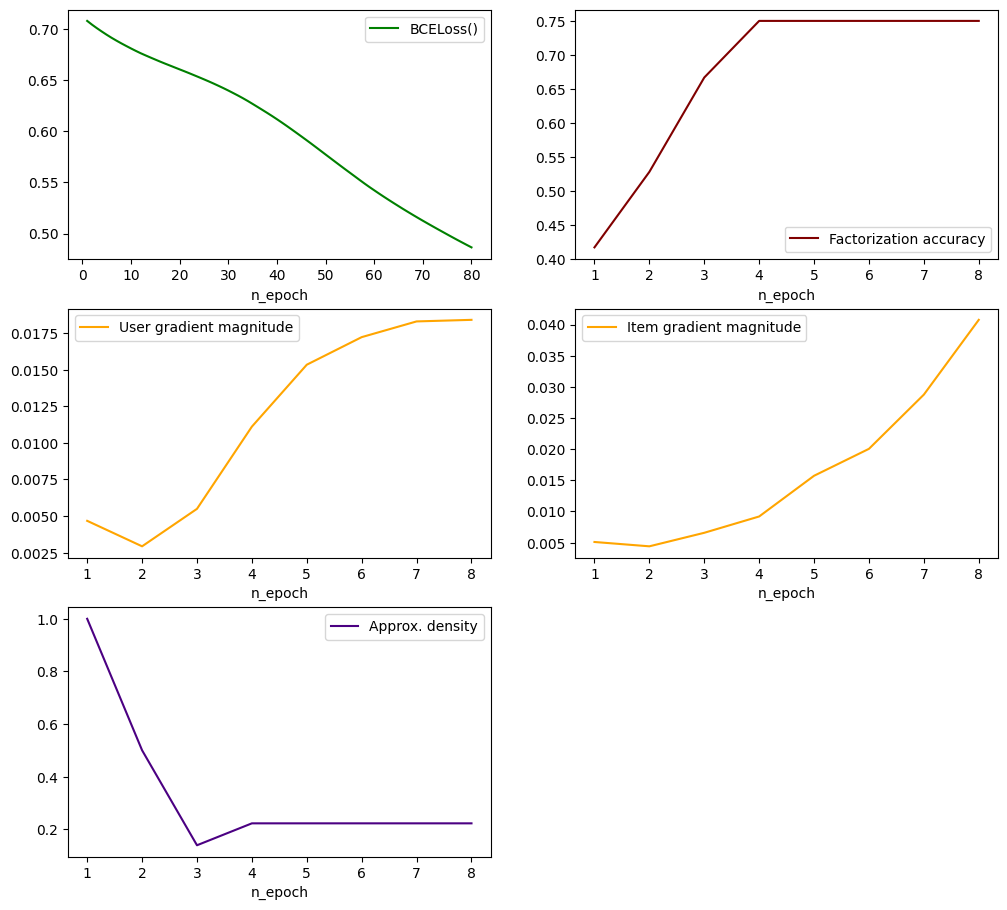

In [48]:
output = train_over_matrix(
    matrix=matrix,
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    batch_size=36, n_epochs=80,
    draw_plots=True              
)

In [10]:
model.get_factors()

(array([[1., 0., 0., 1.],
        [1., 1., 0., 0.],
        [1., 1., 0., 1.],
        [1., 1., 0., 1.],
        [1., 1., 1., 0.],
        [1., 1., 0., 1.]], dtype=float32),
 array([[1., 1., 0., 1.],
        [0., 0., 0., 1.],
        [1., 1., 0., 1.],
        [0., 0., 0., 1.],
        [1., 1., 0., 1.],
        [0., 1., 0., 1.]], dtype=float32))

In [12]:
from torch.autograd import Variable

Variable(torch.tensor(5))

tensor(5)

#### Pure NCF testing

In [49]:
n_users = 6
n_items = 6
emb_size = 4
matrix = utils.get_binary_tensor((n_users, n_items))
# matrix = torch.eye(6, dtype=torch.int8)

model = NeuralMatrixFactorization(
    n_users=n_users,
    n_items=n_items,
    GMF_embedding_dim=emb_size,
    MLP_embedding_dim=emb_size,
    mlp_layers=[32, 32]
)

# criterion = nn.MSELoss()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters())

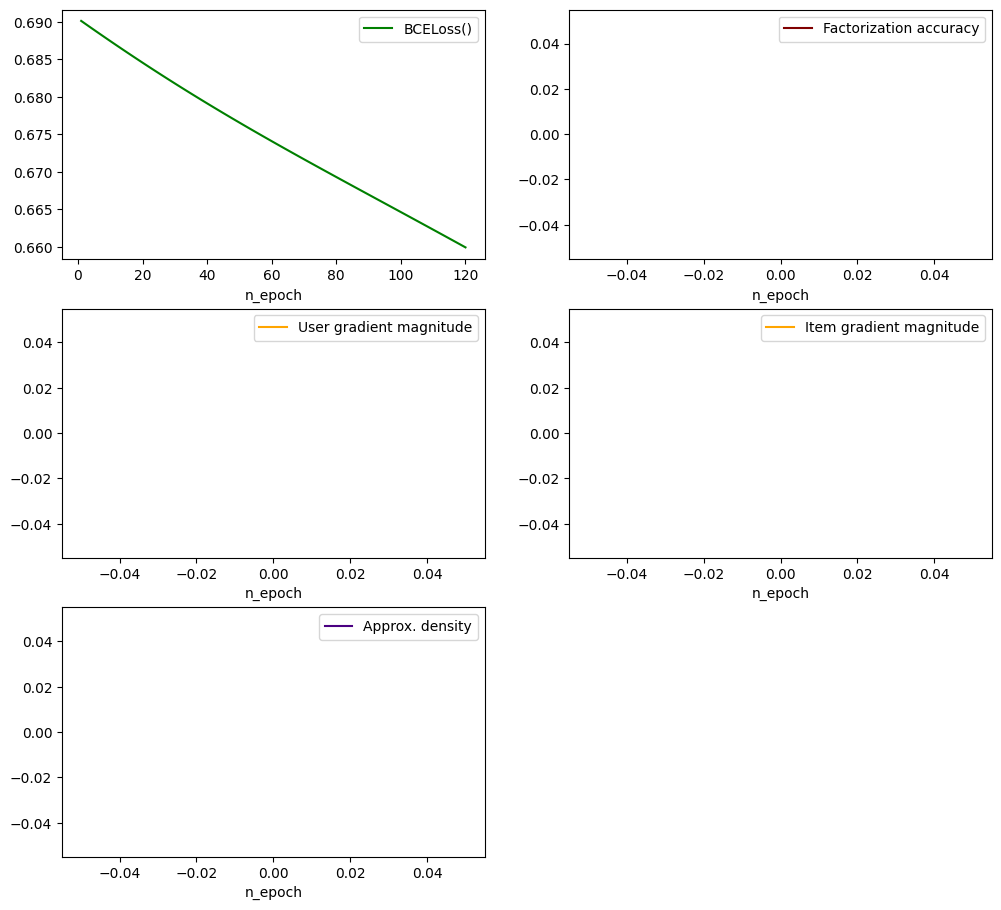

In [50]:
output = train_over_matrix(
    matrix=matrix,
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    batch_size=36, n_epochs=120,
    draw_plots=True               # no dynamic plotting here
)

In [40]:
print(list(model.parameters())[0].grad)

None


#### Binarizer explorations

In [42]:
class AdvancedInputBinarizer_(bm.BinarizerBase):
    def __init__(self, derivative_funct=torch.tanh, t: int = 5):
        super(AdvancedInputBinarizer_, self).__init__()
        self.derivative_funct = derivative_funct
        self.t = t

    def forward(self, x: torch.tensor) -> torch.Tensor:
        x = self.derivative_funct(x * self.t)
        # with torch.no_grad():
        #     x = torch.sign(x)
        return x

In [47]:
ab = AdvancedInputBinarizer_()
t = torch.tensor([1.2, 1.3, 0.1, -10], requires_grad=True)

res = ab(t)
res.backward()

RuntimeError: grad can be implicitly created only for scalar outputs